# Problem setting: Anomaly Detection for fluctuations of Gold Prices (Monthly in USD).

This jupyter notebook demonstrates the change-point detection of [Monthly gold prices since 1950 in USD (London market)](https://datahub.io/core/gold-prices).

## Problem Solution: Encoder/Decoder based on LSTM.

Originally, Long Short-Term Memory(LSTM) networks as a special RNN structure has proven stable and powerful for modeling long-range dependencies.

The Key point of structural expansion is its memory cell which essentially acts as an accumulator of the state information. Every time observed data points are given as new information and input to LSTM's input gate, its information will be accumulated to the cell if the input gate is activated. The past state of cell could be forgotten in this process if LSTM's forget gate is on. Whether the latest cell output will be propagated to the final state is further controlled by the output gate.

This library provides Encoder/Decoder based on LSTM, which is a reconstruction model and makes it possible to extract series features embedded in deeper layers. The LSTM encoder learns a fixed length vector of time-series observed data points and the LSTM decoder uses this representation to reconstruct the time-series using the current hidden state and the value inferenced at the previous time-step.

One interesting application example is the Encoder/Decoder for Anomaly Detection (EncDec-AD) paradigm (Malhotra, P., et al. 2016). This reconstruction model learns to reconstruct normal time-series behavior, and thereafter uses reconstruction error to detect anomalies. Malhotra, P., et al. (2016) showed that EncDec-AD paradigm is robust and can detect anomalies from predictable, unpredictable, periodic, aperiodic, and quasi-periodic time-series. Further, they showed that the paradigm is able to detect anomalies from short time-series (length as small as 30) as well as long time-series (length as large as 500).

### Modeling and Implementation.

Firstly, import Python modules for preprocessing data and building Encoder/Decoder based on LSTM.

In [2]:
import mxnet as mx
import mxnet.ndarray as nd
import numpy as np
import pandas as pd
from mxnet.gluon.nn import Conv2D

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from accelbrainbase.computableloss._mxnet.l2_norm_loss import L2NormLoss
from accelbrainbase.extractabledata.unlabeled_csv_extractor import UnlabeledCSVExtractor
from accelbrainbase.iteratabledata._mxnet.unlabeled_sequential_csv_iterator import UnlabeledSequentialCSVIterator
from accelbrainbase.noiseabledata._mxnet.gauss_noise import GaussNoise
from accelbrainbase.observabledata._mxnet.lstm_networks import LSTMNetworks
from accelbrainbase.observabledata._mxnet.lstmnetworks.encoder_decoder import EncoderDecoder

If you want to observe the learning log, set `getLogger`.

In [3]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("accelbrainbase")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

Load gold price data.

In [4]:
df = pd.read_csv("../../../../Downloads/monthly_csv.csv")
df["date"] = df.Date
df["price"] = df.Price
df.head()

,Date,Price,date,price
0,1950-01,34.73,1950-01,34.73
1,1950-02,34.73,1950-02,34.73
2,1950-03,34.73,1950-03,34.73
3,1950-04,34.73,1950-04,34.73
4,1950-05,34.73,1950-05,34.73


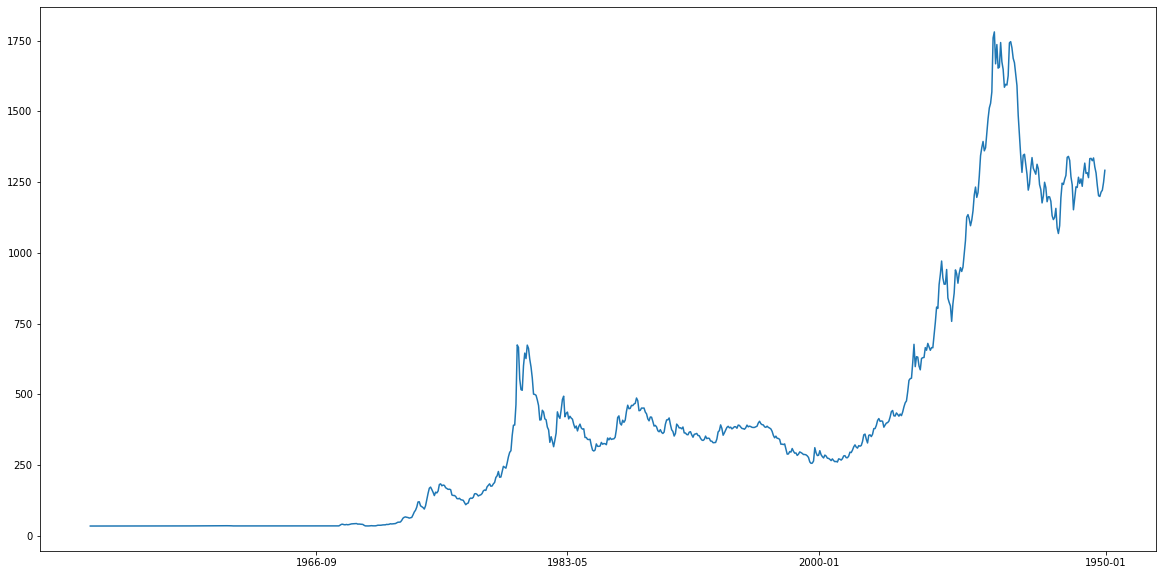

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(df.date.values[20:], df.price.values[20:])
ax.set_xticks([df.date.values[0], df.date.values[200], df.date.values[400], df.date.values[600]])
plt.show()

Here, for convenience, this notebook assumes that threre are two change points. 

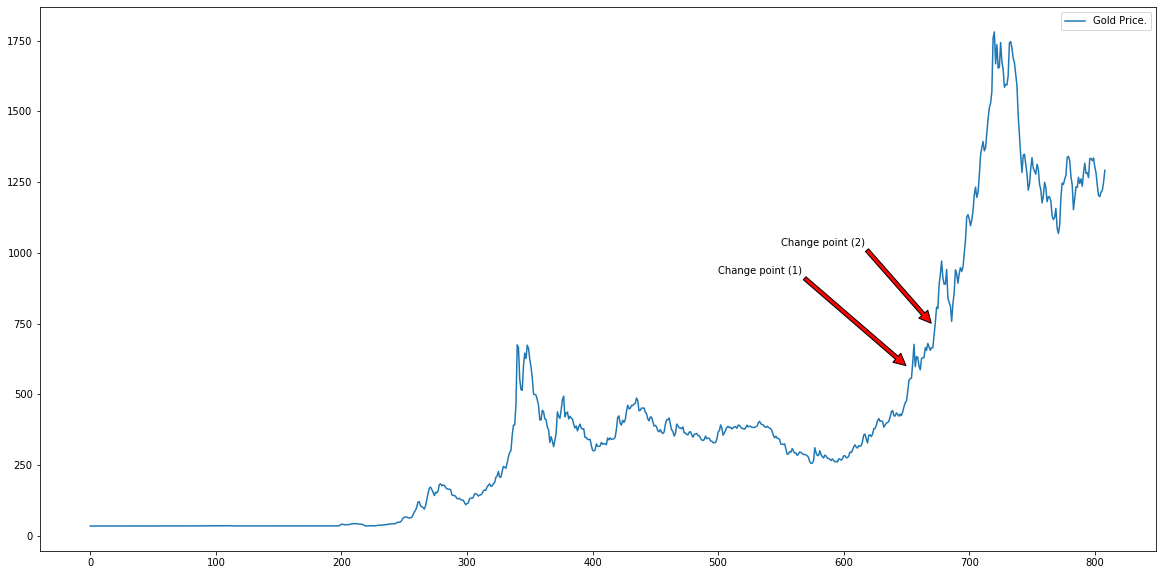

In [78]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(df.price.values[20:], label="Gold Price.")
ax.annotate('Change point (1)', xy=(650, 600), xytext=(500, 925),
            arrowprops=dict(facecolor='red', shrink=0.005),
            )
ax.annotate('Change point (2)', xy=(670, 750), xytext=(550, 1025),
            arrowprops=dict(facecolor='red', shrink=0.005),
            )
plt.legend()
plt.show()

Next, generate the unlabeled samples that are input to the model of the anomaly detector as the logarithmic change rate of the above time series data.

In [7]:
df["pre_price"] = df.price.shift(1)
df["logarithmic_change_rate"] = (df.price / df.pre_price).apply(np.log)
df.tail()

,Date,Price,date,price,pre_price,logarithmic_change_rate
824,2018-09,1199.198,2018-09,1199.198,1201.859,-0.002217
825,2018-10,1214.726,2018-10,1214.726,1199.198,0.012866
826,2018-11,1221.275,2018-11,1221.275,1214.726,0.005377
827,2018-12,1249.887,2018-12,1249.887,1221.275,0.023158
828,2019-01,1291.630,2019-01,1291.630,1249.887,0.032852


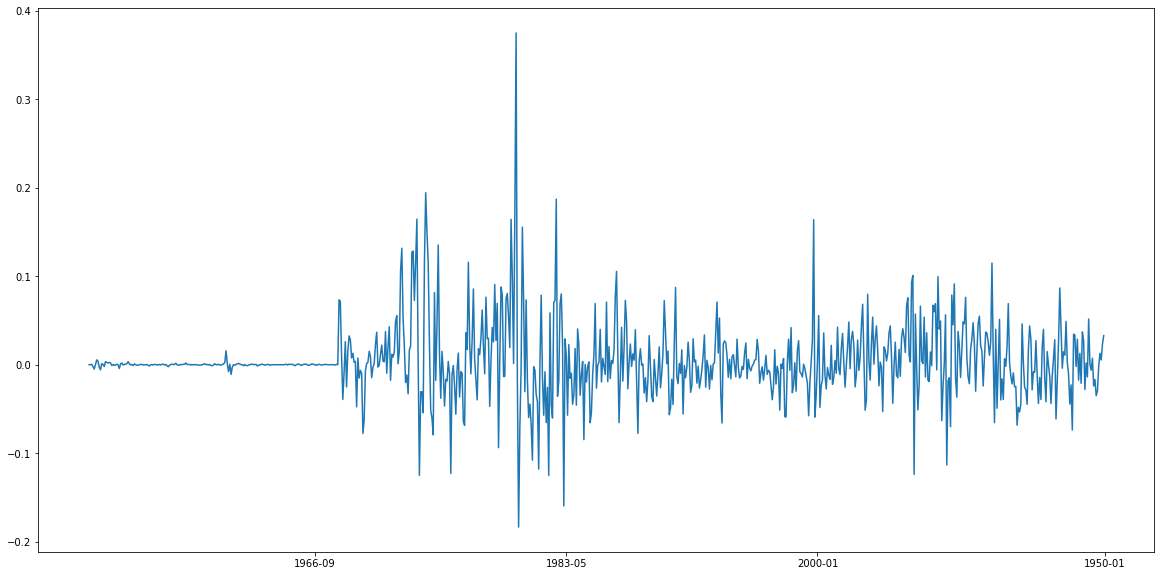

In [8]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(df.date.values[20:], df.logarithmic_change_rate.values[20:])
ax.set_xticks([df.date.values[0], df.date.values[200], df.date.values[400], df.date.values[600]])
plt.show()

Here, for the sake of simplicity, we divide the training and test data by roughly distinguishing the first half and the second half of the year.

In [9]:
df.head(185)

,Date,Price,date,price,pre_price,logarithmic_change_rate
0,1950-01,34.73,1950-01,34.73,NaN,NaN
1,1950-02,34.73,1950-02,34.73,34.73,0.000000
2,1950-03,34.73,1950-03,34.73,34.73,0.000000
3,1950-04,34.73,1950-04,34.73,34.73,0.000000
4,1950-05,34.73,1950-05,34.73,34.73,0.000000
...,...,...,...,...,...,...
180,1965-01,35.13,1965-01,35.13,35.12,0.000285
181,1965-02,35.14,1965-02,35.14,35.13,0.000285
182,1965-03,35.16,1965-03,35.16,35.14,0.000569
183,1965-04,35.14,1965-04,35.14,35.16,-0.000569


In [10]:
df.tail(290).head(100)

,Date,Price,date,price,pre_price,logarithmic_change_rate
539,1994-12,379.480,1994-12,379.480,384.377,-0.012822
540,1995-01,378.738,1995-01,378.738,379.480,-0.001957
541,1995-02,376.745,1995-02,376.745,378.738,-0.005276
542,1995-03,381.820,1995-03,381.820,376.745,0.013381
543,1995-04,391.339,1995-04,391.339,381.820,0.024625
...,...,...,...,...,...,...
634,2002-11,319.255,2002-11,319.255,316.748,0.007884
635,2002-12,333.300,2002-12,333.300,319.255,0.043053
636,2003-01,356.864,2003-01,356.864,333.300,0.068312
637,2003-02,359.575,2003-02,359.575,356.864,0.007568


In [11]:
train_df = df["logarithmic_change_rate"].iloc[180:539]
test_df = df["logarithmic_change_rate"].iloc[540:]

Save each data once.

In [13]:
train_df.to_csv("../../../../Downloads/gold_train.csv", index=False)
test_df.to_csv("../../../../Downloads/gold_test.csv", index=False)

Build and initialize `UnlabeledCSVExtractor` and `UnlabeledSequentialCSVIterator`, specifying parameters such as paths to CSV files.

In [14]:
unlabeled_csv_extractor = UnlabeledCSVExtractor()

In [15]:
unlabeled_csv_iterator = UnlabeledSequentialCSVIterator(
    # is-a `UnlabeledCSVExtractor`.
    unlabeled_csv_extractor=unlabeled_csv_extractor,
    # `str` of Path to CSV file in training.
    train_csv_path="../../../../Downloads/gold_train.csv",
    # `str` of Path to CSV file in test.
    test_csv_path="../../../../Downloads/gold_test.csv",
    # `int` of epochs.
    epochs=1000,
    # `int` of batch size.
    batch_size=40,
    # `int` of the length of series.
    seq_len=3,
    # How to normalize pixel values of images.
    # - `z_score`: Z-Score normalization.
    # - `min_max`: Min-max normalization.
    # - others : This class will not normalize the data.
    norm_mode=None,
    # `float` of scaling factor for data.
    scale=1.0,
    # is-a `NoiseableData`.
    noiseable_data=GaussNoise(sigma=1e-03, mu=0.0),
)

Build and initialize loss function.

In [16]:
computable_loss = L2NormLoss()

Build and initialize `LSTMNetworks` as an encoder.

In [17]:
encoder = LSTMNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `int` of batch size.
    batch_size=40,
    # `int` of the length of series.
    seq_len=3,
    # `int` of the number of units in hidden layer.
    hidden_n=200,
    # `float` of dropout rate.
    dropout_rate=0.0,
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` 
    # that activates observed data points.
    observed_activation="tanh",
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    input_gate_activation="sigmoid",
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in forget gate.
    forget_gate_activation="sigmoid",
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in output gate.
    output_gate_activation="sigmoid",
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in hidden layer.
    hidden_activation="tanh",
    # `bool` that means this class has output layer or not.
    output_layer_flag=False,
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.cpu()` or `mx.gpu()`.
    ctx=mx.gpu(),
)

Build and initialize `LSTMNetworks` as a decoder.

In [18]:
decoder = LSTMNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `int` of batch size.
    batch_size=40,
    # `int` of the length of series.
    seq_len=3,
    # `int` of the number of units in hidden layer.
    hidden_n=200,
    # `int` of the number of units in output layer.
    output_n=1,
    # `float` of dropout rate.
    dropout_rate=0.0,
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` 
    # that activates observed data points.
    observed_activation="tanh",
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    input_gate_activation="sigmoid",
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in forget gate.
    forget_gate_activation="sigmoid",
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in output gate.
    output_gate_activation="sigmoid",
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in hidden layer.
    hidden_activation="tanh",
    # `act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in output layer.
    output_activation="tanh",
    # `bool` that means this class has output layer or not.
    output_layer_flag=True,
    # `bool` for using bias or not in output layer(last hidden layer).
    output_no_bias_flag=True,
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.cpu()` or `mx.gpu()`.
    ctx=mx.gpu(),
)

Build and initialize `EncoderDecoder`, delegating `encoder` and `decoder`.

In [19]:
encoder_decoder = EncoderDecoder(
    # is-a `LSTMNetworks`.
    encoder=encoder,
    # is-a `LSTMNetworks`.
    decoder=decoder,
    # `int` of batch size.
    batch_size=40,
    # `int` of the length of series.
    seq_len=3,
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # is-a `mxnet.initializer` for parameters of model. If `None`, it is drawing from the Xavier distribution.
    initializer=None,
    # `float` of learning rate.
    learning_rate=1e-03,
    # `float` of attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=1.0,
    # `int` of attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # `str` of name of optimizer.
    optimizer_name="SGD",
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.cpu()` or `mx.gpu()`.
    ctx=mx.gpu(),
)

Start learning.

In [20]:
encoder_decoder.learn(unlabeled_csv_iterator)

Epochs: 100 Train loss: 9.5511705e-06 Test loss: 5.1878997e-06
Epochs: 200 Train loss: 1.0924117e-05 Test loss: 1.5137431e-05
Epochs: 300 Train loss: 0.00021395113 Test loss: 7.856346e-06
Epochs: 400 Train loss: 0.0001787952 Test loss: 8.5784395e-06
Epochs: 500 Train loss: 5.4575736e-05 Test loss: 7.756667e-06
Epochs: 600 Train loss: 4.8253103e-05 Test loss: 6.1240353e-06
Epochs: 700 Train loss: 4.0228377e-05 Test loss: 1.0271654e-05
Epochs: 800 Train loss: 2.4050221e-05 Test loss: 1.1129142e-05
Epochs: 900 Train loss: 2.4578014e-05 Test loss: 8.945329e-06
Epochs: 1000 Train loss: 4.217429e-05 Test loss: 1.65962e-05
end. 


Infer the reconstruction map of all test data and calculate the reconstruction errors.

In [35]:
total_test_arr = None
total_error_arr = None
total_reconstructed_arr = None
for _, _, test_arr, _ in unlabeled_csv_iterator.generate_inferenced_samples():
    reconstructed_arr = encoder_decoder.inference(test_arr)
    error_arr = nd.sum(nd.square(reconstructed_arr - test_arr), axis=1)

    if total_test_arr is None:
        total_test_arr = test_arr
    else:
        total_test_arr = nd.concat(total_test_arr, test_arr, dim=0)
    
    if total_error_arr is None:
        total_error_arr = error_arr
    else:
        total_error_arr = nd.concat(total_error_arr, error_arr, dim=0)

    if total_reconstructed_arr is None:
        total_reconstructed_arr = reconstructed_arr
    else:
        total_reconstructed_arr = nd.concat(total_reconstructed_arr, reconstructed_arr, dim=0)

**Note** that the test data extracted `unlabeled_csv_iterator.generate_inferenced_samples()` does not have enough lines for the length of the series.

In [79]:
test_df.shape[0], total_error_arr.shape[0]

(289, 280)

Plot observed data points and reconstructed data points.

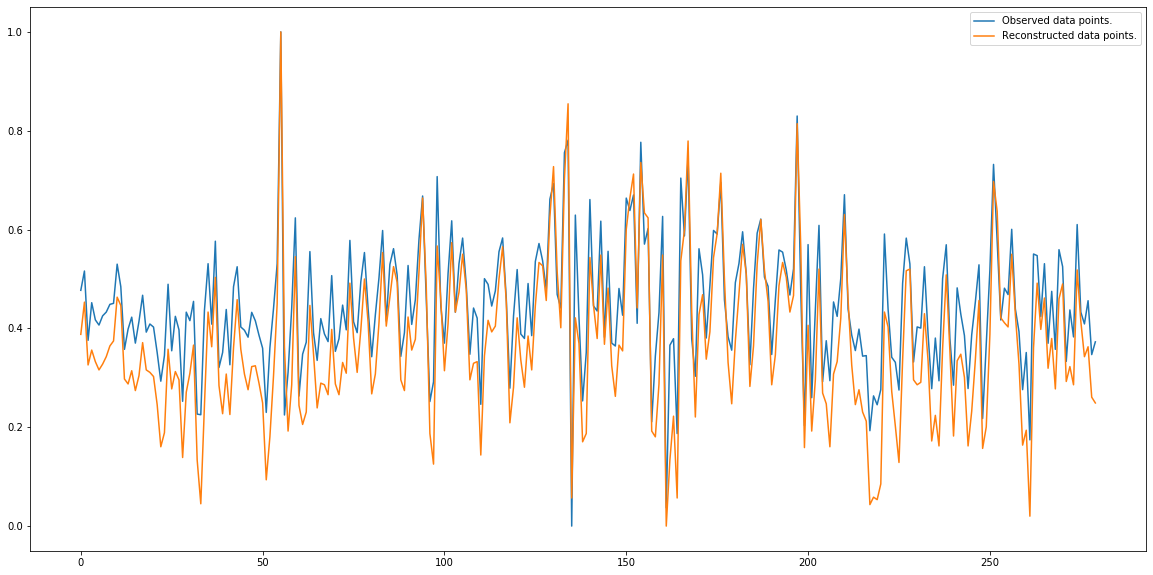

In [38]:
def min_max(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

fig = plt.figure(figsize=(20, 10))
plt.plot(min_max(total_test_arr[:, -1].asnumpy()), label="Observed data points.")
plt.plot(min_max(total_reconstructed_arr[:, -1].asnumpy()), label="Reconstructed data points.")
plt.legend()
plt.show()

Plot reconstructed errors.

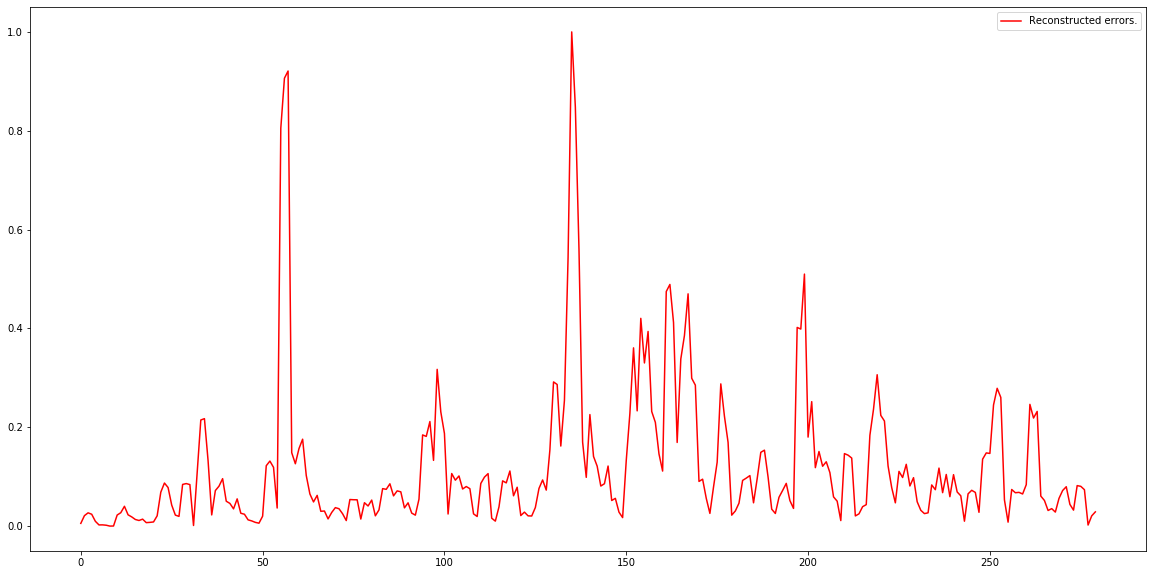

In [66]:
fig = plt.figure(figsize=(20, 10))
plt.plot(min_max(total_error_arr[:, -1].asnumpy()), label="Reconstructed errors.", color="red")
plt.legend()
plt.show()

Let's compare the price time series data and the reconstruction error time series data.

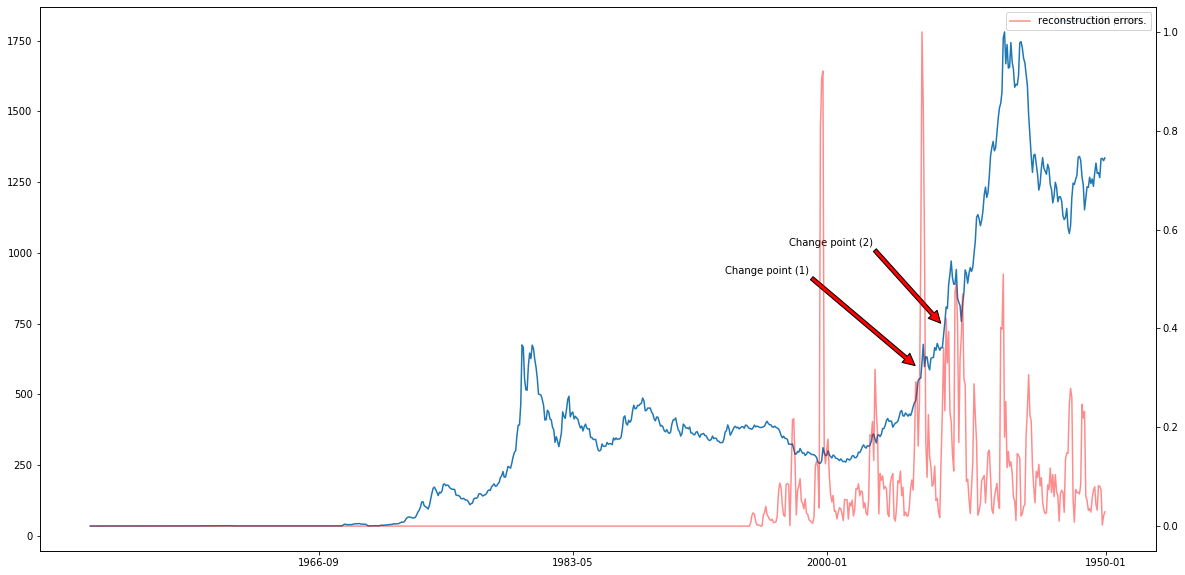

In [81]:
plot_error_arr = np.r_[np.zeros(540), min_max(total_error_arr[:, -1].asnumpy())]

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(df.date.values[20+9:], df.price.values[20+9:], label="Gold prices.")
ax.set_xticks([df.date.values[0], df.date.values[200], df.date.values[400], df.date.values[600]])
ax.annotate('Change point (1)', xy=(650-9, 600), xytext=(500-9, 925),
            arrowprops=dict(facecolor='red', shrink=0.005),
            )
ax.annotate('Change point (2)', xy=(670-9, 750), xytext=(550-9, 1025),
            arrowprops=dict(facecolor='red', shrink=0.005),
            )
ax.legend()
ax2 = ax.twinx()
ax2.plot(df.date.values[20+9:], plot_error_arr[20:], color="red", alpha=0.45, label="reconstruction errors.")
ax2.set_xticks([df.date.values[0], df.date.values[200], df.date.values[400], df.date.values[600]])
ax2.legend()
plt.show()

There are some places where the reconstruction error jumps, not too inconsistent with the original simple assumptions about the change points. However, as shown in the figure, even if it is not anomalous from a human perspective, or even if it does not seem to be a change point, there are also change points with a high degree of anomaly from a not human but model's perspective. The data around January 2000 is an example of this case.

## For ML Ops.

This model inherits [HybridBlock](https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html) from [mxnet.gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html). Functions for common ML Ops such as saving and loading parameters are provided by [HybridBlock](https://mxnet.apache.org/api/python/docs/api/gluon/hybrid_block.html).

# References

- Cho, K., Van Merriënboer, B., Gulcehre, C., Bahdanau, D., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning phrase representations using RNN encoder-decoder for statistical machine translation. arXiv preprint arXiv:1406.1078.
- Malhotra, P., Ramakrishnan, A., Anand, G., Vig, L., Agarwal, P., & Shroff, G. (2016). LSTM-based encoder-decoder for multi-sensor anomaly detection. arXiv preprint arXiv:1607.00148.
- Zaremba, W., Sutskever, I., & Vinyals, O. (2014). Recurrent neural network regularization. arXiv preprint arXiv:1409.2329.